In [1]:
using Distributed,BenchmarkTools,CairoMakie
rmprocs(workers())
addprocs(2;restrict=true)

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\Distributed\src\cluster.jl:1038


2-element Vector{Int64}:
 2
 3

In [2]:
@everywhere using DifferentialEquations,ForwardDiff,DifferentialEquations.EnsembleAnalysis,DiffEqSensitivity

┌ Info: Precompiling DiffEqSensitivity [41bf760c-e81c-5289-8e54-58b1f1f8abe2]
└ @ Base loading.jl:1342
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [3]:
@everywhere begin
    #parameters
    N = 10000000 #community size
    E0 = 10 #init Exposed patients
    beta = 0.00000004 #infection force
    lp = 5.5 #latent period(days)
    ip = 7 #indectious period(days)
    ve = 0.9 #vaccine effectiveness
    vr = 10000 #vaccination rate(per day)
    idr = 365.0f0 #immunity duration for R(days)
    idv = Float32(idr/2) #immunity duration for V(days)
    dr = 0.010458 #death rate(1/9時点の日本の感染状況より算出)
    σS = 1/4 #noise for S
    σE = 1/4 #noise for E
    σI = 1/4 #noise for I
    σR = 1/4 #noise for R
    σV = 1/4 #noise for V
    σD = 1/4 #noise for D
#下の形でないとGPUコンピューティングが利用できない。
    function seirv2(du, u, p, t)
    #=
        S,E,I,R,V,D = u
        beta, lp, ip, ve, vr, σS, σE, σI, σR, σV = p
        du[1] = -beta*S*I - vr + (1/idr)*R + (1/idv)*V
        du[2] = beta*S*I - (1/lp)*E + (1-ve)*beta*V*I
        du[3] = (1/lp)*E - (1/ip)*I
        du[4] = (1/ip)*I - (1/idr)*R
        du[5] = vr - (1-ve)*beta*V*I - (1/idv)*V
    =#
        du[1] = -p[1]*u[1]*u[3] - p[5] + (1/365.0f0)*u[4] + (2/365.0f0)*u[5]
        du[2] = p[1]*u[1]*u[3] - (1/p[2])*u[2] + (1-p[4])*p[1]*u[5]*u[3]
        du[3] = (1/p[2])*u[2] - (1/p[3])*u[3] - p[6]*u[3]
        du[4] = (1/p[3])*u[3] - (1/365.0f0)*u[4]
        du[5] = p[5] - (1-p[4])*p[1]*u[5]*u[3] - (2/365.0f0)*u[5]
        du[6] = p[6]*u[3]
    end
end

In [4]:
@everywhere function seirv_noise(du, u, p, t)
    du[1] = (-p[1]*u[1]*u[3] - p[5] + (1/365.0f0)*u[4] + (2/365.0f0)*u[5])*p[7]
    du[2] = (p[1]*u[1]*u[3] - (1/p[2])*u[2] + (1-p[4])*p[1]*u[5]*u[3])*p[8]
    du[3] = ((1/p[2])*u[2] - (1/p[3])*u[3] - p[6]*u[3])*p[9]
    du[4] = ((1/p[3])*u[3] - (1/365.0f0)*u[4])*p[10]
    du[5] = (p[5] - (1-p[4])*p[1]*u[5]*u[3] - (2/365.0f0)*u[5])*p[11]
    du[6] = (p[6]*u[3])*p[12]
end

In [5]:
@everywhere seirv_prob_st_grad = SDEProblem(seirv2,seirv_noise,Float32[N-E0, E0, 0.0f0, 0.0f0, 0.0f0,0.0f0],(0.0,30.0),Float32[beta, lp, ip, ve, vr, dr, σS, σE, σI, σR, σV, σD], saveat = 0.25f0)

In [6]:
@everywhere seirv_prob_st_base = SDEProblem(seirv2,seirv_noise,Float32[N-E0, E0, 0.0f0, 0.0f0, 0.0f0, 0.0f0],(0.0,500.0),Float32[beta, lp, ip, ve, vr, dr, σS, σE, σI, σR, σV, σD], saveat = 0.25f0)
ensemble_sir_prob_base = EnsembleProblem(seirv_prob_st_base)
ensemble_sir_sol_base = solve(ensemble_sir_prob_base,trajectories = 100,saveat = 10.0f0 ,EnsembleDistributed())
ensemble_sir_mean_base = timeseries_steps_mean(ensemble_sir_sol_base)
nothing

In [7]:
@everywhere ensemble_sir_prob = EnsembleProblem(seirv_prob_st_base)
@everywhere ensemble_sir_sol = solve(ensemble_sir_prob,EnsembleDistributed(),save_everystep=false,trajectories = 100)

In [8]:
@everywhere function jacobain_FW_EN(x;t=30.0, saveat=1,seed=0)
    println(x[1])
    if seed == 0
        _probFW = remake(seirv_prob_st_grad,tspan = (0.0,t))
    else
        _probFW = remake(seirv_prob_st_grad,tspan = (0.0,t),seed = seed)
    end
    ensemble_sir_prob = EnsembleProblem(_probFW)
    ensemble_sir_sol = solve(ensemble_sir_prob,u0=x[1:6],
            p=[x[7],x[8],x[9],x[10],x[11],x[12],σS, σE, σI, σR, σV, σD],save_everystep=false,trajectories = 100)
    function jacobian(x)
        ensemble_sir_sol = solve(ensemble_sir_prob,rtol=1e-6,atol=1e-6,u0=x[1:6],
            p=[x[7],x[8],x[9],x[10],x[11],x[12],σS, σE, σI, σR, σV, σD],save_everystep=false,sensealg=ForwardDiffSensitivity(),trajectories = 100,force_dtmin = true)
        timepoint_mean(ensemble_sir_sol,t)
        #ensemble_sir_sol[end][end]
    end
    quantile05 = timepoint_quantile(ensemble_sir_sol,0.05,t)
    quantile95 = timepoint_quantile(ensemble_sir_sol,0.95,t)
    jacob = ForwardDiff.jacobian(jacobian,x)
    [jacob,quantile05,quantile95]
end

In [9]:
@benchmark jacobain_FW_EN(Float32[N-E0, E0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, beta, lp, ip, ve, vr, dr];t=30,seed=1)

9.99999e6


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface

9.99999e6


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface

9.99999e6


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface

LoadError: InterruptException:

In [10]:
jacob,quantile05,quantile95 = jacobain_FW_EN(Float32[N-E0, E0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, beta, lp, ip, ve, vr, dr];t = 30,seed=1)
jacob

9.99999e6


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface.jl:331
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase C:\Users\tatei\.julia\packages\SciMLBase\DXiE6\src\integrator_interface

LoadError: InterruptException:

In [11]:
inits = []
for i in 1:length(ensemble_sir_mean_base.u)
    u = ensemble_sir_mean_base.u[i]
    push!(inits,[u[1],u[2],u[3],u[4],u[5],u[6],beta, lp, ip, ve, vr, dr])
end

In [12]:
@benchmark pmap(jacobain_FW_EN,inits)

      From worker 3:	9.902605e6
      From worker 2:	9.999997e6


LoadError: InterruptException:

In [ ]:
jacobs_quantiles = map(jacobain_FW_EN,inits)

9.999997e6
9.902605e6

LoadError: InterruptException:

In [ ]:
jacobs_quantiles = pmap(jacobain_FW_EN,inits)

LoadError: InterruptException:

In [ ]:
jacobs = [] #vector{Matrix}
quantile05 = []
quantile95 = []
for i in 1:length(jacobs_quantiles)
    push!(jacobs,jacobs_quantiles[i][1]) 
    push!(quantile05,jacobs_quantiles[i][2])
    push!(quantile95,jacobs_quantiles[i][3])
end

LoadError: UndefVarError: jacobs_quantiles not defined

In [ ]:
jacobs[1][1,:]

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [1]

In [ ]:
quantiles = quantile95 .- quantile05
nothing

InterruptException: InterruptException:

In [ ]:
function jacob_plot(jacobs)
    S=[]
    E=[]
    I=[]
    R=[]
    V=[]
    D=[]
    for i in 1:length(jacobs)
        push!(S,Float64.(jacobs[i][1,:]))
        push!(E,Float64.(jacobs[i][2,:]))
        push!(I,Float64.(jacobs[i][3,:]))
        push!(R,Float64.(jacobs[i][4,:]))
        push!(V,Float64.(jacobs[i][5,:]))
        push!(D,Float64.(jacobs[i][6,:]))
    end
    [S,E,I,R,V,D]
end

InterruptException: InterruptException:

In [ ]:
function slice(VinV ,index)
    a=[]
    for i in 1:length(VinV)
        push!(a,VinV[i][index])
    end
    return (Float32.(a))
end

InterruptException: InterruptException:

In [ ]:
param_names_file = ["S0", "E0", "I0", "R0", "V0", "D0", "beta", "lp", "ip", "ve", "vr", "dr"]

InterruptException: InterruptException:

In [ ]:
var_names = ["S","E","I","R","V","D"]

InterruptException: InterruptException:

      From worker 3:	9.999997e6
      From worker 2:	9.902605e6


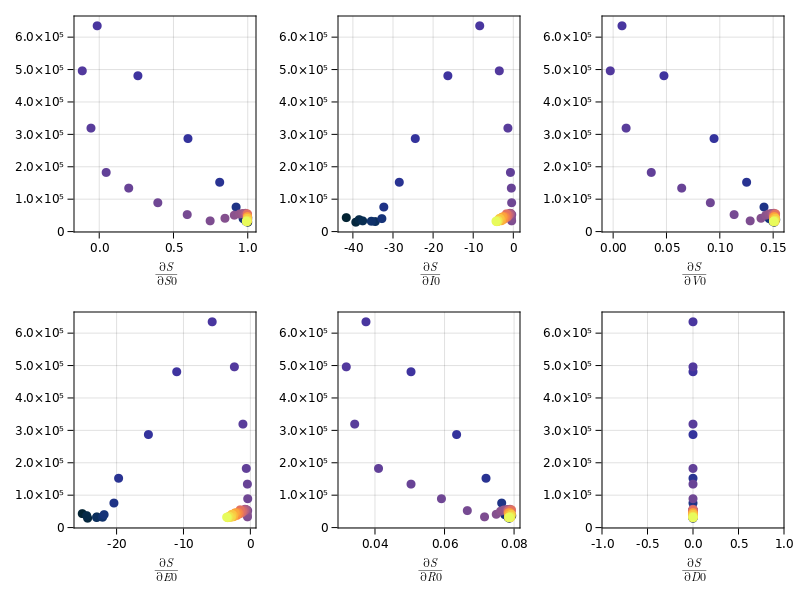

In [23]:
S_grad,E_grad,I_grad,R_grad,V_grad,D_grad = jacob_plot(jacobs)
param_names = [L"\frac{\partial S}{\partial S0}", L"\frac{\partial S}{\partial E0}", L"\frac{\partial S}{\partial I0}",
    L"\frac{\partial S}{\partial R0}", L"\frac{\partial S}{\partial V0}", L"\frac{\partial S}{\partial D0}"
    , L"\frac{\partial S}{\partial beta}", L"\frac{\partial S}{\partial lp}", L"\frac{\partial S}{\partial ip}", 
    L"\frac{\partial S}{\partial ve}", L"\frac{\partial S}{\partial vr}", L"\frac{\partial S}{\partial dr}"]
f1_1 = Figure(fontsize = 12) 
axes1 = [Axis(f1_1[i, j],xlabel = param_names[i+2*j-2]) for i in 1:2, j in 1:3]
for i in 1:length(param_names)
    f1 = Figure(fontsize = 12) 
    ax = Axis(f1[1, 1], xlabel = param_names[i], ylabel = "S_90%quantile")
    scatter!(ax, slice(S_grad,i),slice(quantiles,1),color = 1:length(S_grad), colormap = :thermal)
    save(string("S/S_",param_names_file[i],".pdf"), f1, pt_per_unit = 1)
end
for (i, ax) in enumerate(axes1)
    scatter!(ax, slice(S_grad,i),slice(quantiles,1),color = 1:length(S_grad), colormap = :thermal)
end
save("S/S_u0.pdf", f1_1, pt_per_unit = 1)
f1_1

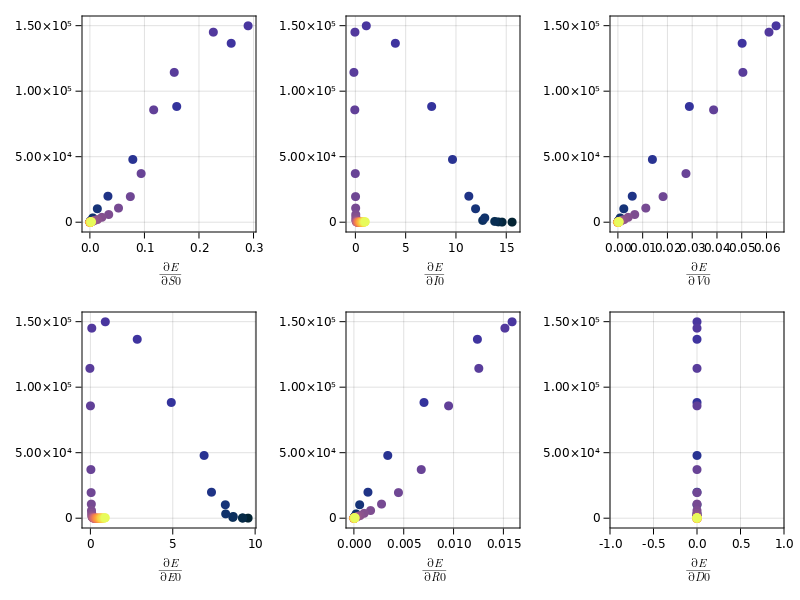

In [24]:
param_names = [L"\frac{\partial E}{\partial S0}", L"\frac{\partial E}{\partial E0}", L"\frac{\partial E}{\partial I0}",
    L"\frac{\partial E}{\partial R0}", L"\frac{\partial E}{\partial V0}", L"\frac{\partial E}{\partial D0}"
    , L"\frac{\partial E}{\partial beta}", L"\frac{\partial E}{\partial lp}", L"\frac{\partial E}{\partial ip}", 
    L"\frac{\partial E}{\partial ve}", L"\frac{\partial E}{\partial vr}", L"\frac{\partial E}{\partial dr}"]
f2_1 = Figure(fontsize = 12) 
axes1 = [Axis(f2_1[i, j],xlabel = param_names[i+2*j-2]) for i in 1:2, j in 1:3]
for i in 1:length(param_names)
    f2 = Figure(fontsize = 12) 
    ax = Axis(f2[1, 1], xlabel = param_names[i], ylabel = "E_90%quantile")
    scatter!(ax, slice(E_grad,i),slice(quantiles,2),color = 1:length(S_grad), colormap = :thermal)
    save(string("E/E_",param_names_file[i],".pdf"), f2, pt_per_unit = 1)
end
for (i, ax) in enumerate(axes1)
    scatter!(ax, slice(E_grad,i),slice(quantiles,2),color = 1:length(S_grad), colormap = :thermal)
end
save("E/E_u0.pdf", f2_1, pt_per_unit = 1)
f2_1

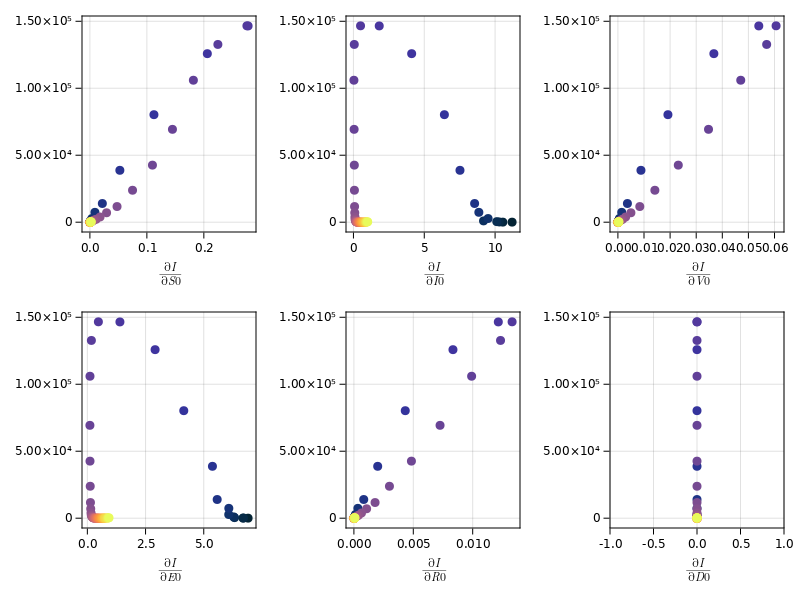

In [25]:
param_names = [L"\frac{\partial I}{\partial S0}", L"\frac{\partial I}{\partial E0}", L"\frac{\partial I}{\partial I0}",
    L"\frac{\partial I}{\partial R0}", L"\frac{\partial I}{\partial V0}", L"\frac{\partial I}{\partial D0}"
    , L"\frac{\partial I}{\partial beta}", L"\frac{\partial I}{\partial lp}", L"\frac{\partial I}{\partial ip}", 
    L"\frac{\partial I}{\partial ve}", L"\frac{\partial I}{\partial vr}", L"\frac{\partial I}{\partial dr}"]
f3_1 = Figure(fontsize = 12) 
axes1 = [Axis(f3_1[i, j],xlabel = param_names[i+2*j-2]) for i in 1:2, j in 1:3]
for i in 1:length(param_names)
    f3 = Figure(fontsize = 12) 
    ax = Axis(f3[1, 1], xlabel = param_names[i], ylabel = "I_90%quantile")
    scatter!(ax, slice(I_grad,i),slice(quantiles,3),color = 1:length(S_grad), colormap = :thermal)
    save(string("I/I_",param_names_file[i],".pdf"), f3, pt_per_unit = 1)
end
for (i, ax) in enumerate(axes1)
    scatter!(ax, slice(I_grad,i),slice(quantiles,3),color = 1:length(S_grad), colormap = :thermal)
end
save("I/I_u0.pdf", f3_1, pt_per_unit = 1)
f3_1

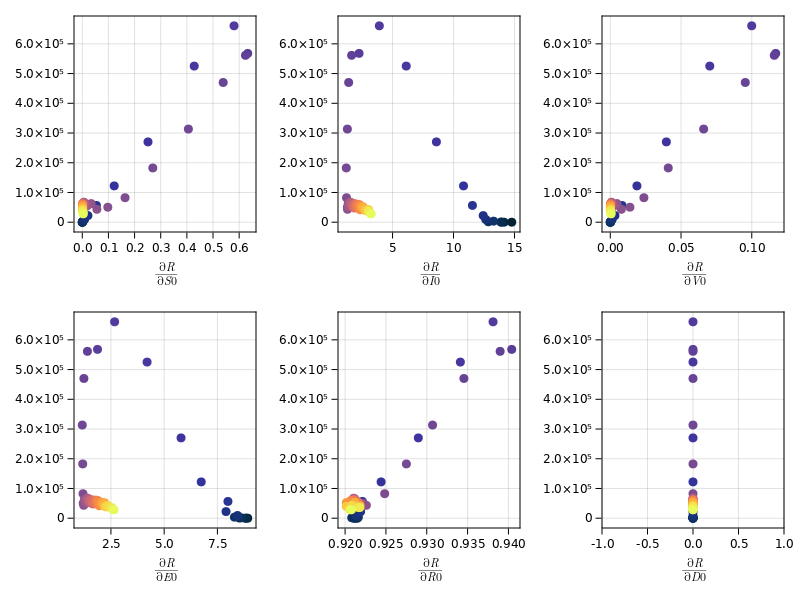

In [26]:
param_names = [L"\frac{\partial R}{\partial S0}", L"\frac{\partial R}{\partial E0}", L"\frac{\partial R}{\partial I0}",
    L"\frac{\partial R}{\partial R0}", L"\frac{\partial R}{\partial V0}", L"\frac{\partial R}{\partial D0}"
    , L"\frac{\partial R}{\partial beta}", L"\frac{\partial R}{\partial lp}", L"\frac{\partial R}{\partial ip}", 
    L"\frac{\partial R}{\partial ve}", L"\frac{\partial R}{\partial vr}", L"\frac{\partial R}{\partial dr}"]
f4_1 = Figure(fontsize = 12) 
axes1 = [Axis(f4_1[i, j],xlabel = param_names[i+2*j-2]) for i in 1:2, j in 1:3]
for i in 1:length(param_names)
    f4 = Figure(fontsize = 12) 
    ax = Axis(f4[1, 1], xlabel = param_names[i], ylabel = "R_90%quantile")
    scatter!(ax, slice(R_grad,i),slice(quantiles,4),color = 1:length(S_grad), colormap = :thermal)
    save(string("R/R_",param_names_file[i],".pdf"), f4, pt_per_unit = 1)
end
for (i, ax) in enumerate(axes1)
    scatter!(ax, slice(R_grad,i),slice(quantiles,4),color = 1:length(S_grad), colormap = :thermal)
end
save("R/R_u0.pdf", f4_1, pt_per_unit = 1)
f4_1

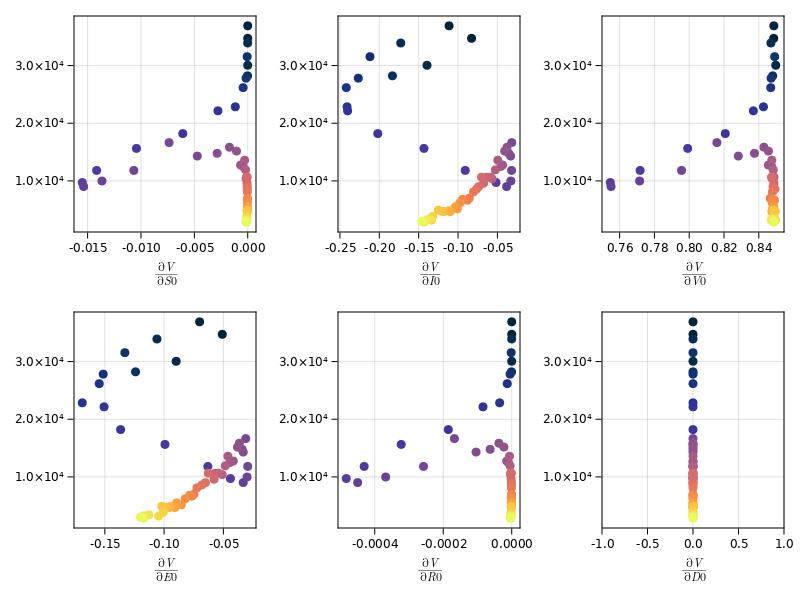

In [27]:
param_names = [L"\frac{\partial V}{\partial S0}", L"\frac{\partial V}{\partial E0}", L"\frac{\partial V}{\partial I0}",
    L"\frac{\partial V}{\partial R0}", L"\frac{\partial V}{\partial V0}", L"\frac{\partial V}{\partial D0}"
    , L"\frac{\partial V}{\partial beta}", L"\frac{\partial V}{\partial lp}", L"\frac{\partial V}{\partial ip}", 
    L"\frac{\partial V}{\partial ve}", L"\frac{\partial V}{\partial vr}", L"\frac{\partial V}{\partial dr}"]
f5_1 = Figure(fontsize = 12) 
axes1 = [Axis(f5_1[i, j],xlabel = param_names[i+2*j-2]) for i in 1:2, j in 1:3]
for i in 1:length(param_names)
    f5 = Figure(fontsize = 12) 
    ax = Axis(f5[1, 1], xlabel = param_names[i], ylabel = "V_90%quantile")
    scatter!(ax, slice(V_grad,i),slice(quantiles,5),color = 1:length(S_grad), colormap = :thermal)
    save(string("V/V_",param_names_file[i],".pdf"), f5, pt_per_unit = 1)
end
for (i, ax) in enumerate(axes1)
    scatter!(ax, slice(V_grad,i),slice(quantiles,5),color = 1:length(S_grad), colormap = :thermal)
end
save("V/V_u0.pdf", f5_1, pt_per_unit = 1)
f5_1

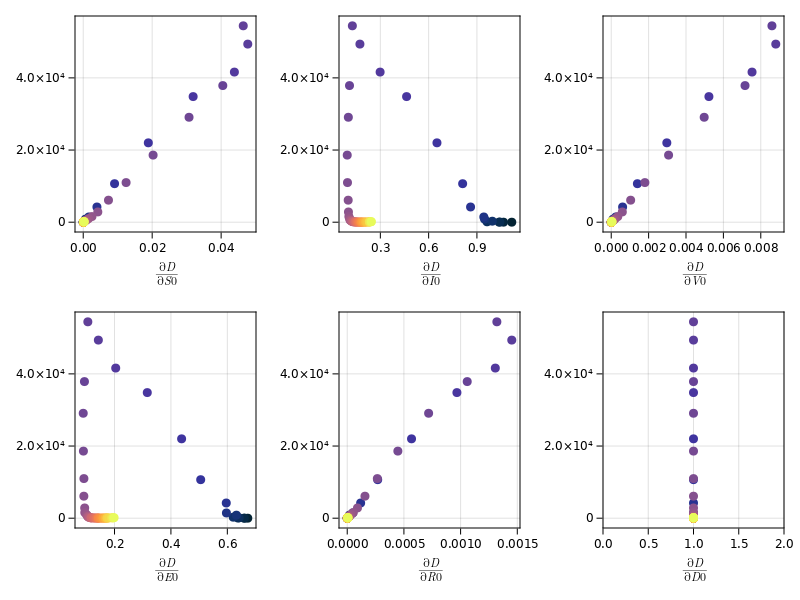

In [28]:
param_names = [L"\frac{\partial D}{\partial S0}", L"\frac{\partial D}{\partial E0}", L"\frac{\partial D}{\partial I0}",
    L"\frac{\partial D}{\partial R0}", L"\frac{\partial D}{\partial V0}", L"\frac{\partial D}{\partial D0}"
    , L"\frac{\partial D}{\partial beta}", L"\frac{\partial D}{\partial lp}", L"\frac{\partial D}{\partial ip}", 
    L"\frac{\partial D}{\partial ve}", L"\frac{\partial D}{\partial vr}", L"\frac{\partial D}{\partial dr}"]
f6_1 = Figure(fontsize = 12) 
axes1 = [Axis(f6_1[i, j],xlabel = param_names[i+2*j-2]) for i in 1:2, j in 1:3]
for i in 1:length(param_names)
    f6 = Figure(fontsize = 12) 
    ax = Axis(f6[1, 1], xlabel = param_names[i], ylabel = "D_90%quantile")
    scatter!(ax, slice(D_grad,i),slice(quantiles,6),color = 1:length(S_grad), colormap = :thermal)
    save(string("D/D_",param_names_file[i],".pdf"), f6, pt_per_unit = 1)
end
for (i, ax) in enumerate(axes1)
    scatter!(ax, slice(D_grad,i),slice(quantiles,6),color = 1:length(S_grad), colormap = :thermal)
end
save("D/D_u0.pdf", f6_1, pt_per_unit = 1)
f6_1

In [69]:
rmprocs(workers())

Task (done) @0x0000000083534200